In [7]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
#import torch.utils.tensorboard as tb
from Preprocessing.preprocessing_sorted import PreprocessingTrainingData
from torch.utils.data.sampler import SequentialSampler
import seaborn as sns
import matplotlib.pyplot as  plt
import os
import logging
torch.set_printoptions(profile="full")
import pandas as pd

In [2]:
#static parameters
train_batch_size = 30
val_batch_size = 30
sequence_length=50
test_batch_size = 1
input_size = 1
hidden_size = 256
num_layer = 2
output_size = 38
clip = 3

In [3]:
#get data from preprocessing.py
dataset_path = os.path.join(os.path.abspath('..'),'Dataset\\Clementi dataset\\Clementi dataset' )
network_input,network_output,max_midi_number,min_midi_number,int_to_note = PreprocessingTrainingData().preprocess_notes(dataset_path)
network_input, network_output = network_input.cuda(), network_output.cuda()

# print(network_input)
#print(network_output)

In [4]:
print(network_output.max())
print(network_output.min())

tensor(37, device='cuda:0')
tensor(0, device='cuda:0')


In [5]:
#network_output

In [6]:
print(network_input.max())
print(network_input.min())
print(max_midi_number)
print(min_midi_number)
print(int_to_note)

tensor(1.)
tensor(0.5618)
89
50
{0: 50, 1: 52, 2: 53, 3: 54, 4: 55, 5: 56, 6: 57, 7: 58, 8: 59, 9: 60, 10: 61, 11: 62, 12: 63, 13: 64, 14: 65, 15: 66, 16: 67, 17: 68, 18: 69, 19: 70, 20: 71, 21: 72, 22: 73, 23: 74, 24: 75, 25: 76, 26: 77, 27: 78, 28: 79, 29: 80, 30: 81, 31: 82, 32: 83, 33: 84, 34: 85, 35: 86, 36: 88, 37: 89}


In [7]:
'''
data is highly unbalanced
# '''
# sns.distplot(torch.tensor(network_output).cpu())
# xx = pd.DataFrame(torch.tensor(network_output).cpu())
# xx.groupby(0).size().to_frame(name='values')

'\ndata is highly unbalanced\n# '

In [8]:
'''
to make batch of equal sizes
Quick Fix
'''
network_input = network_input[: -29]
network_output = network_output[: -29]

print(network_input.shape)
print(network_output.shape)

torch.Size([1800, 50, 1])
torch.Size([1800])


In [9]:
# # Bakchodi Normalization
# network_input=network_input.cpu().numpy().tolist()
# for i in range(len(network_input)):
#     for j in range(len(network_input[i])):
#         network_input[i][j][0]=((network_input[i][j][0])*(max_midi_number-min_midi_number)+min_midi_number)/max_midi_number
# network_input=torch.Tensor(network_input).cuda()

In [10]:
#network_input[:10]

In [11]:
'''
create Stacked LSTM model
'''
class Stacked_LSTM(nn.Module):
    def __init__(self,input_size, hidden_size, num_layers, output_size):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm1 = nn.LSTM(input_size = input_size, hidden_size = hidden_size, batch_first = True)
        self.lstm2 = nn.LSTM(input_size = hidden_size, hidden_size = output_size,batch_first = True)
        
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(output_size, output_size)
        
        
    def forward(self, x, batch_size):
        
        output, _ = self.lstm1(x)        
        #print(output.shape)
        
        #output = self.dropout(output)
        
        output, _ = self.lstm2(output)
        #print(output.shape)
        
        # stack up lstm outputs
        output = output.contiguous().view(-1, 38)
        #print(output.shape)
        
        output = self.dropout(output)
        output = self.linear(output)
        #print('Linear Output :-',output.shape)
        
        #output = F.softmax(output, dim = 1)
        #print('SOFTMAX OUTPUT :--', output)
        
        
        # reshape to be batch_size first
        output = output.view(batch_size, -1)
        #print('Reshape to batch size first :-',output.shape)
        
        output = output[:, -self.output_size:] # get last batch of labels
        #print('Final Output :-',output)
        #print('RESHAPE SIZE :-', output.shape)
        
        return output

#initialize the weights of LSTM using Xavier initialization    
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight) 

In [12]:
'''
Divide the dataset into train/val 
'''
train_size = 0.8
indices = list(range(len(network_input)))
split = int(np.floor(train_size*len(network_input)))
train_idx, val_idx = indices[:split], indices[split:]

train_sampler = SequentialSampler(train_idx)
val_sampler = SequentialSampler(val_idx)

dataset = TensorDataset(network_input,network_output)
train_loader = DataLoader(dataset, batch_size= train_batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size= val_batch_size,sampler= val_sampler)

In [13]:
import torch.optim as optimizer

model = Stacked_LSTM(input_size,hidden_size,num_layer,output_size)
model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optimizer.AdamW(model.parameters())
#optimizer = optimizer.RMSprop(model.parameters(), lr = 0.001, weight_decay = 0.01)


#make sure to transfer model to GPU after initializing optimizer
model.cuda()

Stacked_LSTM(
  (lstm1): LSTM(1, 256, batch_first=True)
  (lstm2): LSTM(256, 38, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=38, out_features=38, bias=True)
)

In [14]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
)

In [15]:
epochs = 700
min_val_loss = np.Inf

for e in range(epochs):
    
    train_loss = 0
    val_loss = 0
    train_accuracy = 0
    val_accuracy = 0
    
    for inputs,labels in train_loader:
        #print(inputs.shape)

        '''
        Creating new variables for the hidden state, otherwise
        we'd backprop through the entire training history
        '''
        
        # zero accumulated gradients
        model.zero_grad()
       
        # get the output from the model
        output = model.forward(inputs, train_batch_size)
        #print('OUTPUT', output)
        
        
        #print('Labels Shape :-', (torch.max(labels, 1)[1]).shape)
    
        # calculate the loss and perform backprop
        #print('Labels Long :-', labels.long())
        loss = criterion(output,labels.long())
        #print('LOSS IS :-', loss)
        
        loss.backward()
        
        #calculate training accuracy
        output = F.softmax(output, dim = 1)
        top_p, top_class = output.topk(1, dim=1)
        logging.debug(' top probab {} top class {}'.format(top_p.view(-1, top_p.shape[0]), top_class.view(-1, top_p.shape[0])))

        equals = top_class == labels.long().view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        #nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        train_loss += loss.item()
        #print(train_loss)
              
    model.eval()
    for inputs, labels in val_loader:
                
        output = model.forward(inputs, val_batch_size)
       
        loss = criterion(output,labels.long())
        
        val_loss += loss.item()
        
        #calculate validation accuracy
        output = F.softmax(output, dim = 1)
        top_p, top_class = output.topk(1, dim=1)
        
        #logging.debug(output)
        #logging.debug('VALIDATION top probab {} VALIDATION top class {}'.format(top_p.view(-1, top_p.shape[0]), top_class.view(-1, top_p.shape[0])))

        #print('Top Class:- ',top_class)
        equals = top_class == labels.long().view(*top_class.shape)
        #print('Equals:- ', equals)
        val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
    model.train()
    
    #Averaging losses
    train_loss = train_loss/len(train_loader)
    val_loss = val_loss/len(val_loader)
    val_accuracy = val_accuracy/len(val_loader)
    train_accuracy = train_accuracy/len(train_loader)
    
    print('Epoch: {}\tTrain Loss: {:.7f} \tVal Loss:{:.7f} \tTrain Acc: {:.7}% \tVal Acc: {:.7f}%'.format(e, train_loss, val_loss, train_accuracy*100,val_accuracy*100))
    
    #saving the model if validation loss is decreased
    if val_loss <= min_val_loss:
        print('Validation Loss decreased from {:6f} to {:6f}, saving the model weights'.format(min_val_loss, val_loss))
        torch.save(model.state_dict(), 'lstm_state_256-38-our_normalization_bakchodi.pt')
        min_val_loss = val_loss

Epoch: 0	Train Loss: 3.6334269 	Val Loss:3.4586551 	Train Acc: 3.75% 	Val Acc: 8.8888892%
Validation Loss decreased from    inf to 3.458655, saving the model weights
Epoch: 1	Train Loss: 3.4967090 	Val Loss:3.4123434 	Train Acc: 3.958333% 	Val Acc: 8.8888892%
Validation Loss decreased from 3.458655 to 3.412343, saving the model weights
Epoch: 2	Train Loss: 3.4343334 	Val Loss:3.2786045 	Train Acc: 5.069445% 	Val Acc: 8.8888892%
Validation Loss decreased from 3.412343 to 3.278604, saving the model weights
Epoch: 3	Train Loss: 3.3904500 	Val Loss:3.2091378 	Train Acc: 4.375% 	Val Acc: 8.8888892%
Validation Loss decreased from 3.278604 to 3.209138, saving the model weights
Epoch: 4	Train Loss: 3.3593954 	Val Loss:3.1820642 	Train Acc: 5.0% 	Val Acc: 8.8888892%
Validation Loss decreased from 3.209138 to 3.182064, saving the model weights
Epoch: 5	Train Loss: 3.3481151 	Val Loss:3.1723341 	Train Acc: 4.791667% 	Val Acc: 8.8888892%
Validation Loss decreased from 3.182064 to 3.172334, saving 

Epoch: 62	Train Loss: 2.6936753 	Val Loss:2.6053655 	Train Acc: 13.40278% 	Val Acc: 12.5000005%
Epoch: 63	Train Loss: 2.6747660 	Val Loss:2.5761303 	Train Acc: 15.90278% 	Val Acc: 11.9444449%
Validation Loss decreased from 2.580883 to 2.576130, saving the model weights
Epoch: 64	Train Loss: 2.6596414 	Val Loss:2.5898408 	Train Acc: 15.83333% 	Val Acc: 12.5000005%
Epoch: 65	Train Loss: 2.6641835 	Val Loss:2.5824909 	Train Acc: 16.11111% 	Val Acc: 13.3333337%
Epoch: 66	Train Loss: 2.6638518 	Val Loss:2.5576372 	Train Acc: 15.41667% 	Val Acc: 12.5000004%
Validation Loss decreased from 2.576130 to 2.557637, saving the model weights
Epoch: 67	Train Loss: 2.6431375 	Val Loss:2.5598120 	Train Acc: 16.66667% 	Val Acc: 14.4444449%
Epoch: 68	Train Loss: 2.6338044 	Val Loss:2.5516669 	Train Acc: 16.59722% 	Val Acc: 15.0000005%
Validation Loss decreased from 2.557637 to 2.551667, saving the model weights
Epoch: 69	Train Loss: 2.6372640 	Val Loss:2.5625014 	Train Acc: 16.18056% 	Val Acc: 13.8888894

Epoch: 126	Train Loss: 2.2637879 	Val Loss:2.1128978 	Train Acc: 27.56945% 	Val Acc: 31.9444449%
Validation Loss decreased from 2.117526 to 2.112898, saving the model weights
Epoch: 127	Train Loss: 2.2608598 	Val Loss:2.1057869 	Train Acc: 26.94445% 	Val Acc: 30.8333341%
Validation Loss decreased from 2.112898 to 2.105787, saving the model weights
Epoch: 128	Train Loss: 2.2643013 	Val Loss:2.1240274 	Train Acc: 26.25% 	Val Acc: 32.2222228%
Epoch: 129	Train Loss: 2.3341103 	Val Loss:2.1045726 	Train Acc: 26.66667% 	Val Acc: 33.3333341%
Validation Loss decreased from 2.105787 to 2.104573, saving the model weights
Epoch: 130	Train Loss: 2.2619911 	Val Loss:2.0360711 	Train Acc: 27.5% 	Val Acc: 35.8333339%
Validation Loss decreased from 2.104573 to 2.036071, saving the model weights
Epoch: 131	Train Loss: 2.2937876 	Val Loss:2.0688519 	Train Acc: 26.875% 	Val Acc: 32.2222230%
Epoch: 132	Train Loss: 2.2631938 	Val Loss:2.0567730 	Train Acc: 26.73611% 	Val Acc: 35.0000006%
Epoch: 133	Train L

Epoch: 187	Train Loss: 1.5847565 	Val Loss:1.2703393 	Train Acc: 48.05556% 	Val Acc: 66.6666662%
Epoch: 188	Train Loss: 1.5461112 	Val Loss:1.1684767 	Train Acc: 50.76389% 	Val Acc: 70.2777786%
Validation Loss decreased from 1.215132 to 1.168477, saving the model weights
Epoch: 189	Train Loss: 1.5133356 	Val Loss:1.1954581 	Train Acc: 52.91667% 	Val Acc: 68.3333335%
Epoch: 190	Train Loss: 1.5221955 	Val Loss:1.2206020 	Train Acc: 52.84722% 	Val Acc: 66.6666674%
Epoch: 191	Train Loss: 1.5258612 	Val Loss:1.1512225 	Train Acc: 50.90278% 	Val Acc: 68.6111117%
Validation Loss decreased from 1.168477 to 1.151223, saving the model weights
Epoch: 192	Train Loss: 1.5051169 	Val Loss:1.1285702 	Train Acc: 50.34722% 	Val Acc: 70.0000008%
Validation Loss decreased from 1.151223 to 1.128570, saving the model weights
Epoch: 193	Train Loss: 1.5003233 	Val Loss:1.1124006 	Train Acc: 50.34722% 	Val Acc: 73.3333339%
Validation Loss decreased from 1.128570 to 1.112401, saving the model weights
Epoch: 19

Epoch: 249	Train Loss: 0.7997848 	Val Loss:0.4448572 	Train Acc: 75.90278% 	Val Acc: 91.1111106%
Validation Loss decreased from 0.453028 to 0.444857, saving the model weights
Epoch: 250	Train Loss: 0.7859303 	Val Loss:0.4464096 	Train Acc: 75.0% 	Val Acc: 90.8333331%
Epoch: 251	Train Loss: 0.7889689 	Val Loss:0.4297475 	Train Acc: 75.27778% 	Val Acc: 91.3888882%
Validation Loss decreased from 0.444857 to 0.429747, saving the model weights
Epoch: 252	Train Loss: 0.7832603 	Val Loss:0.4018155 	Train Acc: 75.34722% 	Val Acc: 91.9444437%
Validation Loss decreased from 0.429747 to 0.401815, saving the model weights
Epoch: 253	Train Loss: 0.7247728 	Val Loss:0.4085759 	Train Acc: 77.84722% 	Val Acc: 90.8333331%
Epoch: 254	Train Loss: 0.7312702 	Val Loss:0.3910477 	Train Acc: 77.98611% 	Val Acc: 91.6666657%
Validation Loss decreased from 0.401815 to 0.391048, saving the model weights
Epoch: 255	Train Loss: 0.7295601 	Val Loss:0.4155309 	Train Acc: 78.54167% 	Val Acc: 91.6666657%
Epoch: 256	Tr

Validation Loss decreased from 0.135770 to 0.129781, saving the model weights
Epoch: 312	Train Loss: 0.3402483 	Val Loss:0.1364914 	Train Acc: 90.69444% 	Val Acc: 96.9444434%
Epoch: 313	Train Loss: 0.3491890 	Val Loss:0.1330011 	Train Acc: 90.625% 	Val Acc: 96.6666659%
Epoch: 314	Train Loss: 0.3346975 	Val Loss:0.1482885 	Train Acc: 90.06944% 	Val Acc: 96.6666659%
Epoch: 315	Train Loss: 0.3618614 	Val Loss:0.1399375 	Train Acc: 90.13889% 	Val Acc: 97.2222219%
Epoch: 316	Train Loss: 0.3548529 	Val Loss:0.1181016 	Train Acc: 90.90278% 	Val Acc: 97.7777774%
Validation Loss decreased from 0.129781 to 0.118102, saving the model weights
Epoch: 317	Train Loss: 0.3439632 	Val Loss:0.1144071 	Train Acc: 89.79167% 	Val Acc: 98.0555549%
Validation Loss decreased from 0.118102 to 0.114407, saving the model weights
Epoch: 318	Train Loss: 0.3621009 	Val Loss:0.1176705 	Train Acc: 90.0% 	Val Acc: 97.4999999%
Epoch: 319	Train Loss: 0.6131971 	Val Loss:0.5165411 	Train Acc: 80.27778% 	Val Acc: 85.27777

Epoch: 383	Train Loss: 0.1959186 	Val Loss:0.0489974 	Train Acc: 95.06944% 	Val Acc: 99.1666665%
Epoch: 384	Train Loss: 0.1751861 	Val Loss:0.0467453 	Train Acc: 96.04167% 	Val Acc: 98.8888890%
Epoch: 385	Train Loss: 0.1778570 	Val Loss:0.0507377 	Train Acc: 95.41667% 	Val Acc: 98.8888885%
Epoch: 386	Train Loss: 0.1834961 	Val Loss:0.0512096 	Train Acc: 95.41667% 	Val Acc: 98.8888890%
Epoch: 387	Train Loss: 0.1747073 	Val Loss:0.0405209 	Train Acc: 95.83333% 	Val Acc: 99.1666665%
Validation Loss decreased from 0.043968 to 0.040521, saving the model weights
Epoch: 388	Train Loss: 0.2047414 	Val Loss:0.0569365 	Train Acc: 94.58333% 	Val Acc: 98.3333329%
Epoch: 389	Train Loss: 0.2271417 	Val Loss:0.0423867 	Train Acc: 93.61111% 	Val Acc: 99.1666665%
Epoch: 390	Train Loss: 0.1844900 	Val Loss:0.0401228 	Train Acc: 95.69444% 	Val Acc: 99.1666665%
Validation Loss decreased from 0.040521 to 0.040123, saving the model weights
Epoch: 391	Train Loss: 0.1767757 	Val Loss:0.0469129 	Train Acc: 94.

Epoch: 458	Train Loss: 0.1144196 	Val Loss:0.0217776 	Train Acc: 97.5% 	Val Acc: 99.1666665%
Epoch: 459	Train Loss: 0.1105025 	Val Loss:0.0211817 	Train Acc: 97.15278% 	Val Acc: 99.1666665%
Epoch: 460	Train Loss: 0.1194557 	Val Loss:0.0215966 	Train Acc: 96.45833% 	Val Acc: 99.1666665%
Epoch: 461	Train Loss: 0.1255931 	Val Loss:0.0219419 	Train Acc: 96.73611% 	Val Acc: 98.8888885%
Epoch: 462	Train Loss: 0.1281422 	Val Loss:0.0259165 	Train Acc: 96.66667% 	Val Acc: 98.8888885%
Epoch: 463	Train Loss: 0.1075597 	Val Loss:0.0259850 	Train Acc: 97.43056% 	Val Acc: 99.1666665%
Epoch: 464	Train Loss: 0.1146186 	Val Loss:0.0246508 	Train Acc: 96.73611% 	Val Acc: 99.1666660%
Epoch: 465	Train Loss: 0.1072948 	Val Loss:0.0238099 	Train Acc: 97.15278% 	Val Acc: 99.1666665%
Epoch: 466	Train Loss: 0.1007921 	Val Loss:0.0215547 	Train Acc: 97.84722% 	Val Acc: 99.1666660%
Epoch: 467	Train Loss: 0.1049922 	Val Loss:0.0203328 	Train Acc: 97.36111% 	Val Acc: 99.1666660%
Validation Loss decreased from 0.0

## MUSIC GENERATION

In [26]:
#load weights
test_model = Stacked_LSTM(input_size,hidden_size,num_layer,output_size)
test_model.load_state_dict(torch.load('lstm_state_256-38-our_normalization_bakchodi.pt'))
test_model.eval()
test_model.cuda()

Stacked_LSTM(
  (lstm1): LSTM(1, 256, batch_first=True)
  (lstm2): LSTM(256, 38, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=38, out_features=38, bias=True)
)

In [27]:
#load population database
#testing_data = np.ones(200)*1
# testing_data = list(range(50,90))
# testing_data.extend(testing_data[::-1])
# testing_data_rev = testing_data[::-1]
# testing_data_rev.extend(testing_data)
# testing_data_rev.extend(testing_data_rev)
# testing_data = testing_data_rev


# testing_data = np.asarray(testing_data)
# testing_data = testing_data.reshape(testing_data.shape[0],1)

initial_seq = [network_input[0][1:].cpu().numpy().tolist()]

testing_data_unnorm = testing_data

In [28]:
#abc

In [29]:
list1=[]
testing_data=testing_data.tolist()
for i in range(len(testing_data)):
    list1.extend(testing_data[i])

#list1

for i in range(len(list1)):
    list1[i]=(list1[i]-50)/(89-50)
#     list1[i]=(list1[i])/(89)

list1 = np.asarray(list1)
list1 = list1.reshape(list1.shape[0],1)
testing_data = list1
#list1

In [30]:
#testing_data

In [31]:
#Predicting
def prediction_with_influence(influence,int2note,initial_seq, max_note, min_note,test_batch_size = 1):

    predicted_notes = []
    initial_seq[0].extend([[0]]*len(testing_data))
    test_seq = torch.Tensor(initial_seq).cuda()
    
    for i in range(len(influence)):
        
        test_seq[0][sequence_length - 1 + i][0] = float(influence[i])
        
        test_slice = test_seq[0][i : i + sequence_length]        
        test_slice = test_slice.view(1, test_slice.shape[0], test_slice.shape[1])
        
        test_output = test_model.forward(test_slice, test_batch_size)
    
        test_output = F.softmax(test_output, dim = 1)
        top_p, top_class = test_output.topk(1,dim =1)
        
        test_seq[0][sequence_length - 1 + i][0] = (int2note[top_class.item()] - min_note)/(max_note - min_note)
#         test_seq[0][sequence_length - 1 + i][0] = int2note[top_class.item()]/max_note
        
        predicted_notes.append(int2note[top_class.item()])
        
    return predicted_notes

In [32]:
predicted_notes_lst = prediction_with_influence(testing_data,int_to_note,initial_seq, max_midi_number, min_midi_number)

In [33]:
#predicted_notes_lst

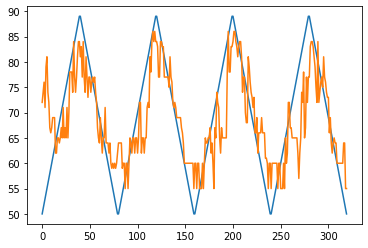

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

#plt.plot(list(np.ones(200)*89))

#plt.plot(list(np.ones(200)*50))
#plt.plot(list(np.ones(20)*50))
plt.plot(testing_data_unnorm*89)
plt.plot(predicted_notes_lst)

In [25]:
from collections import Counter
c = Counter(predicted_notes_lst)
c

Counter({72: 15,
         74: 22,
         76: 17,
         78: 10,
         79: 10,
         81: 19,
         83: 9,
         67: 7,
         77: 82,
         88: 10,
         86: 19,
         82: 22,
         89: 5,
         84: 45,
         71: 14,
         73: 7,
         69: 5,
         75: 1,
         80: 1})

In [46]:
from Postprocessing.postprocessing import PostProcessing
PostProcessing().generate_midi_file('hello.midi', predicted_notes_lst)

In [45]:
#int_to_note